In [1]:
from __future__ import annotations
import numpy as np
import numpy.linalg as lin
import networkx as nx
import scipy
import scipy.sparse.linalg as slin
import matplotlib.pyplot as plt

#  Basic Functionality 

Here we supply the essential functions needed for experiments. This includes the ability to find the term relating to the spectral norm which is abstracted in a function because it may change. 

Also included a generators for ER graphs, the ability to compute the optimal price vector for a graph and the optimal profit of a graph if we were to apply this price vector. 

In [2]:
# Linear algebra
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=np.inf)
    # return np.sqrt(slin.eigs(A.T @ A, k=1, which="LM", return_eigenvectors=False, tol=1e-10)[0])


# Graph makers
def makeSimilarGraph(G: nx.DiGraph) -> np.matrix:
    """ Generates the new graph with the same in/out degree as the orginal
        -------
        Return adj. matrix of graph
    """
    sequence_in = [d for _, d in G.in_degree]
    sequence_out = [d for _, d in G.out_degree]
    return nx.to_numpy_matrix(
        nx.directed_configuration_model(sequence_in, sequence_out, create_using=nx.DiGraph),
        dtype="d"
    )


# Graph Generators
def makeERGraph(n: int, p: float) -> np.matrix:
    """ Generates Random Erdos-Renyi Graphs with n vertices and link probability p
        ------
        return Adjacency graph of matrix and the networkx DiGraph object
    """
    G = nx.generators.fast_gnp_random_graph(n, p, directed=True)
    # sortG = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
    return nx.to_numpy_matrix(G, dtype="d"), G

def makePowerGraph(n : int):
    G = nx.generators.scale_free_graph(n)
    return nx.to_numpy_array(G, dtype="d"), G

def centralty(A: np.matrix, rho: float, alpha,k) -> np.matrix:
    """

    Parameters
    ----------
    A : np matrix
    rho : network effect

    Returns
    -------
    Centrality vector as described in paper
    """
    n = A.shape[0]

    ident = np.eye(n, n)
    ones = np.ones((n, 1))
    ApA = A + A.T
    eig = specNorm(ApA)
    alpha = rho / eig
    central = lin.inv(ident - (alpha * ApA))
    central = central @ ones  # Checked.  this > 0
    return central


# Paper related properties
def applyPriceVector(A: np.matrix, v: np.matrix, rho: float, a: int | float, c: int | float) -> (float, bool):
    """

    Parameters
    ----------
    A : Graph
    v : price vector
    rho : network strength
    a : Stand alone strength
    c : Marginal cost. Should be less than a

    Returns
    -------
    Profit in this network if prces v were applied.
    And if result is valid or not
    """
    n = A.shape[0]
    ident = np.eye(n, n)
    ones = np.ones((n, 1))
    ApA = A + A.T
    # spN = specNorm(ApA)  # Sometimes scipy return x+0i, this is to discard warning
    alpha = (rho / specNorm(ApA))
    consumption = (2 * alpha) * A
    consumption = ident - consumption
    consumption = 0.5 * lin.inv(consumption)  # This is entirely in the range [0,1] ^ checked

    consumption = consumption @ ((a * ones) - v)
    valid = 1
    if (np.min(consumption) < 0):
        valid = 0
    return ((v - (c * ones)).T @ consumption)[0, 0], valid


def priceVector(A: np.matrix, rho: float, a: int | float, c: int | float,k = None) -> np.matrix:
    """
    Parameters
    ----------
    A : Network
    rho : network strength
    a : stand alone util
    c : marginal cost. Should be less than a

    Returns
    -------
    Vector reprsenting what price to charge individual i
    """
    n = A.shape[0]
    ones = np.ones((n, 1))
    spec = specNorm(A + A.T)
    alpha = rho / spec
    central = centralty(A, rho, alpha,k)  # This should be A not A + A.T because of how centralty function is designed
    dif = A - A.T
    pv1 = ((a + c) / 2) * ones
    pv2 = ((a - c) * alpha * 0.5) * (dif @ central)
    return pv1 + pv2


def optimalProfit(A: np.matrix, n: int, a: int | float, c: int | float, rho: float):
    """
    Parameters
    ----------
    A : Network
    n : size of network
    rho : network strength
    a : stand alone util
    c : marginal cost. Should be less than a
    Returns
    -------
    True profit. Should be the same as applyPriceVector(A, pricevector(A,...),...)
    """
    one = np.ones((n, 1))
    alpha = rho / specNorm(A + A.T)

    t1 = lin.inv(np.eye(n, n) - (alpha * (A + A.T)))
    total = one.T @ t1 @ one
    total = ((a - c) * (a - c) / 8) * total
    return np.real(total[0, 0])



# Metrics
Here are functions used "one level up" in terms of abstraction from finding the price vectors. This includes things like computing the fractional regret of a applying a given vector v to a graph instad of its true optimal price vector. 

In [3]:

def fractionalRegret(A, v, n, rho, a, c):
    """

    Parameters
    ----------
    A : Network
    v : price vector to compare to
    rho : network strength
    n : number of nodes
    a : stand alone util
    c : marginal cost. Should be less than a

    Returns
    -------
    1 - (profit of A using v)/(profit of A using best choice)
    """
    discrim = optimalProfit(A, n, a, c, rho)  # Optimal profit
    # I have check and the formula for optimal profit does match applypricevector(A, pricevector(A,...), params)
    appliedProf,v  = applyPriceVector(A, v, rho, a, c) # Profit at v
    return 1 - (appliedProf / discrim) , v 



# Gaps applying price vector of guesses to true graph G
def getGapRev(A, test, rho, a, c):
    """ Apply optimal profit price vector guess graph to test graph test and A. Return pair of profits"""
    optimalVector = priceVector(test, rho, a, c)
    profitWithGuessV = applyPriceVector(A, optimalVector, rho, a, c)
    trueProfit = applyPriceVector(A, priceVector(A, rho, a, c), rho, a, c)
    return trueProfit, profitWithGuessV


# Applying the true optimal profit vector to guesses
# Currently not using because it seems backwards of what I want
def getGaps(n, p, rho, a, c, i, results, n_trials):
    A, G = makeERGraph(n, p)
    results[i] = np.average([getGap(A, makeSimilarGraph(G), rho, a, c) for j in range(n_trials)])
    return i


# Apply the price vector that each guess produces to the true graph and take average.
def getGapsReverse(n, p, rho, a, c, i, results, n_trials):
    A, G = makeERGraph(n, p)
    results[i] = np.average([getGapRev(A, makeSimilarGraph(G), rho, a, c) for j in range(n_trials)])
    return i


# Here we apply the average optimal price vector of the guesses to the true graph G
# I get a warning about discarding complex values, values should never complex for this problem
# and when I check they are all +0i so ?


def getAverageGap(n, p, rho, a, c, i, results, n_trials):
    A, G = makeERGraph(n, p)
    n = A.shape[0]
    trueProfit = applyPriceVector(A, priceVector(A, rho, a, c), rho, a, c)
    # the average vector initilized with sample size of 1
    averageV = priceVector(makeSimilarGraph(G), rho, a, c)
    # And another n_trials-1 trials
    for j in range(n_trials - 1):
        averageV += priceVector(makeSimilarGraph(G), rho, a, c)
    averageV /= n_trials  # Scaling
    profit, v = applyPriceVector(A, averageV, rho, a, c)
    results[i] = np.real(trueProfit - profit)


# Tests
Here are the collection of various tests we can run. 

In [45]:
def profitDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    trueP = optimalProfit(A_true,n, a, c, rho)
    res_par = np.zeros((n_trials,))
    res_seq = np.zeros((n_trials,))
    valid_par = 0
    valid_seq = 0    
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        res_par[j],b0 = applyPriceVector(A_true, v_par, rho, a, c)
        res_seq[j],b1 = applyPriceVector(A_true, v_seq, rho, a, c)
        valid_par += b0
        valid_seq += b1
        
    return [res_par, res_seq], [valid_par/n_trials, valid_seq/n_trials]

def normDistribution(n: int, p : float, n_trials : int):
    results = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    true_norm = specNorm(A_true + A_true.T)
    res_par = np.zeros((n_trials,))
    res_seq = np.zeros((n_trials,))
    valid_par = 0
    valid_seq = 0    
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        res_par[j] = specNorm(A_par + A_par.T)
        res_seq[j] = specNorm(A_seq + A_seq.T)
    return res_par, res_seq, true_norm

def centrDistribution(n: int, p : float, n_trials : int):
    results = np.zeros(n_trials)
    ident = np.eye(n,n)
    v_one = np.ones((n,1))
    A_true, G_true = makeERGraph(n, p)
    GG = A_true + A_true.T
    true_cent = lin.inv(ident - 0.9*GG) @ v_one
    res_par = np.zeros((n_trials,))
    res_seq = np.zeros((n_trials,))
    valid_par = 0
    valid_seq = 0    
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        AA = A_par + A_par.T
        BB = A_seq + A_seq.T
        par_cent = lin.inv(ident - 0.9*AA) @ v_one
        par_dist = lin.norm(par_cent - true_cent)/n
        seq_cent = lin.inv(ident - 0.9*BB) @ v_one
        seq_dist = lin.norm(seq_cent - true_cent)/n
        res_par[j] = par_dist
        res_seq[j] = seq_dist
    return res_par, res_seq

def regretDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    trueP = optimalProfit(A_true,n, a, c, rho)
    res_par = []
    res_seq = []
    valid_par = 0
    valid_seq = 0 
    uniformV = (a+c)/2 * np.ones((n,1))   
    uniform_res = fractionalRegret(A_true, uniformV, n, rho, a, c)[0]
    seq_count = 0
    par_count = 0
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        temp, b0= fractionalRegret(A_true, v_par, n, rho, a, c)
        if(b0): 
            res_par.append(temp)
            par_count += 1
        temp, b1 = fractionalRegret(A_true, v_seq, n, rho, a, c)
        if(b1):
            res_seq.append(temp)
            seq_count += 1
        valid_par += b0
        valid_seq += b1
        
    return [res_par, res_seq, uniform_res], [valid_par/n_trials, valid_seq/n_trials]

def regretAveragedVector(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    trueP = optimalProfit(A_true,n, a, c, rho)
    v_aver = np.zeros((n,1))
    res_par = np.zeros((n_trials,))
    res_seq = np.zeros((n_trials,))
    valid_par = 0
    valid_seq = 0    
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        A_seq = makeSimilarGraph(G_true)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        v_aver += v_seq
        res_par[j],b0 = fractionalRegret(A_true, v_par, n, rho, a, c)
        res_seq[j],b1 = fractionalRegret(A_true, v_seq, n, rho, a, c)
        valid_par += b0
        valid_seq += b1
    v_aver /= n_trials
    res_avg, b0 = fractionalRegret(A_true, v_aver, n, rho, a, c)
    return [res_par, res_seq, res_avg], [valid_par/n_trials, valid_seq/n_trials]

def walkDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float,k : int):
    results = np.zeros(n_trials)
    res = np.zeros((n_trials,))
    for j in range(n_trials):
        A_true, G_true = makeERGraph(n, p)
        trueP = optimalProfit(A_true,n, a, c, rho)
        v = priceVector(A_true, rho, a, c,k)
        res[j] = fractionalRegret(A_true, v, n, rho, a, c)[0]
    return res

def rawProfitDistribution(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float):
    results = np.zeros(n_trials)
    res_par = []
    res_seq = []
    A_true, G_true = makeERGraph(n, p)
    trueP = optimalProfit(A_true,n, a, c, rho)
    for j in range(n_trials):
        A_seq = makeSimilarGraph(G_true)
        A_par, G_par = makeERGraph(n,p)
        v_par = priceVector(A_par, rho, a, c)
        v_seq = priceVector(A_seq, rho, a, c)
        res_par.append(applyPriceVector(A_true, v_par, rho, a, c)[0])
        res_seq.append(applyPriceVector(A_true, v_seq, rho, a, c)[0])
    return res_par, res_seq, trueP

def priceVectorDifference(n : int, p : float,  n_trials : int, rho : float, a : int | float ,c : int | float, norm = None):
    res_par = np.zeros(n_trials)
    res_seq = np.zeros(n_trials)
    A_true, G_true = makeERGraph(n, p)
    v_tre = priceVector(A_true, rho, a, c)
    for j in range(n_trials):
        A_par, G_par = makeERGraph(n,p)
        v_par = priceVector(A_par, rho, a, c)
        res_par[j] = np.linalg.norm(v_tre - v_par, ord=norm)
        A_seq = makeSimilarGraph(G_true)
        v_seq = priceVector(A_seq, rho, a, c)
        res_seq[j] = np.linalg.norm(v_tre - v_seq,  ord = norm)
    return res_par, res_seq



# Effects of different Norms
Reporting for n=1500, rho=0.9, p=sqrt(log(n))/n, a=5, c=4 the variance of profits and the fraction of valid samples. 

# The variance of the norm


In [56]:
def specNorm(A : np.matrix) -> float:
    return lin.norm(A, ord="fro")
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 100
rho = 0.9
a = 5
c = 4
par_res, seq_res, actual = normDistribution(n,p,n_trials)
print(np.mean(par_res))
print(np.mean(seq_res))
print(actual)


90.15505434446146
89.48964898630511
89.47625383307015


# The effect of a uniform norm

In [52]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
[res_par, res_seq] = centrDistribution(n, p, n_trials)
print("Constant")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))

Constant
Same Parameter var 9.189770189991696
Same Sequence var 3150.489614249467
Same Parameter mean 0.8166024864276856
Same Sequence mean 8.580772273455073


(None, None)

## Infinity Norm

In [53]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=np.inf)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 5
rho = 0.9
a = 5
c = 4
[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("Infinity Norm")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

Infinity Norm
Same Parameter var 7.376580039211012
Same Sequence var 0.00011376386644586377
Same Parameter mean 279.02077728039086
Same Sequence mean 299.28727227143145
Same Parameter ratio 1.0
Same Sequence ratio 1.0


(None, None)

## Frobenieus Norm
It appears this norm is 2 large so the network effect is small

In [27]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("Frob Norm")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

Frob Norm
Same Parameter var 3.84199330243273e-05
Same Sequence var 4.028751473149182e-09
Same Parameter mean 197.97369431609926
Same Sequence mean 198.21021263676067
Same Parameter ratio 1.0
Same Sequence ratio 1.0


(None, None)

## 1 Norm

In [25]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)
n =  2000
p = np.sqrt(np.log(n))/n
n_trials = 5
rho = 1.5
a = 5
c = 4
#[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq, regret_uniform], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("One Norm")
#print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
#print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Averager Regret", np.mean(regret_par), np.mean(regret_seq))
print("Variance Regret", np.var(regret_par), np.var(regret_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

One Norm
Averager Regret 0.0018495036109807516 4.072385666826772e-05
Variance Regret 3.9134372978438404e-07 1.728425834122235e-11
Same Parameter ratio 1.0
Same Sequence ratio 1.0


(None, None)

## Nuclear norm

In [20]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord="nuc")
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 50
rho = 0.9
a = 5
c = 4
#[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
#[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
#print("One Norm")
#print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
#print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
#print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)

## 2 Norm
This is very confusing and worrying. The results show that under the 2 norm same parameter graphs are likely to be malformed often. Also this code takes much longer to run than the others

In [39]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=2)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 5
rho = 0.9
a = 5
c = 4
"""
[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
[regret_par, regret_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
print("2 Norm")
print("Same Parameter var", np.var(res_par)), print("Same Sequence var", np.var(res_seq))
print("Same Parameter mean", np.mean(res_par)), print("Same Sequence mean", np.mean(res_seq))
print("Same Parameter ratio", ratio_par), print("Same Sequence ratio", ratio_seq)"""

6.655559293332528
6.4503003180383125
6.568853258211817
6.438693326476057
6.575948608334404
6.488428244461536
6.617215135396985
6.472310980513896
6.6300433678057935
6.463659882624446
6.678728338206497
6.500874364608128
6.4807755478106355
6.482758220739494
6.681091733787972
6.504995239066338
6.577979442682579
6.495678325982651
6.648476013238334
6.463146931266644
2 Norm
Same Parameter var 13776.143625999268
Same Sequence var 120.66868048170959
Same Parameter mean -1250.3585347939859
Same Sequence mean 1021.1496637457176
Same Parameter ratio 0.0
Same Sequence ratio 0.2


(None, None)

We conclude that seemingly any choice of norm besides 2-norm is sufficient. It is unclear to me if I need to weight these norms in someway to be bigger/smamer.

# Limited Walk Size
One question we have asked is if knowing the degrees of each matrix is sufficient perhaps knowing the reach of each node in two steps is better because it specifies the graph more. Here instead of generating new graphs specificied by this information we will look at the regret using only the true graph but with truncated centralities

In [22]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)
def centralty(A: np.matrix, rho: float, alpha, k=None) -> np.matrix:
    """

    Parameters
    ----------
    A : np matrix
    rho : network effect
    k : size of walk to take in network

    Returns
    -------
    Centrality vector as described in paper
    """
    n = A.shape[0]
    if k is None:

        ident = np.eye(n, n)
        ones = np.ones((n, 1))
        ApA = A + A.T
        eig = specNorm(ApA)
        alpha = rho / eig
        central = lin.inv(ident - (alpha * ApA))
        central = central @ ones  # Checked.  this > 0
        return central
    else:
        one = np.ones((n,1))
        ApA = A + A.T
        alpha = rho / specNorm(ApA)
        total = np.eye(n,n)
        base = alpha * ApA
        old = 0 
        for i in range(1,k+1):
            old = total
            total = total + np.linalg.matrix_power(base, i)
            dif = total - old
            if np.linalg.norm(dif) < 1e-6:
                print("Converged with i = ", i)
                break
        return total @ one   

In [18]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)
n = 1500
p = np.sqrt(np.log(n))/n
n_trials = 3
rho = 0.99
a = 5
c = 4
ks = [1,2,3,5,10,15, 20]
walk_loss = []
for k in ks:
    v = walkDistribution(n,p,n_trials,  rho, a, c, k)
    walk_loss.append(np.mean(v))   
    print(np.mean(v))



1
1
1
0.001466894085102662
2
2
2
0.0004851934791999894
3
3
3
5.7697455208671755e-05
5
5
5
4.6762420889967515e-06
10
10
10
9.732574376049759e-10
15
15
15
5.833851920063656e-13
20
Converged with i =  17
20
Converged with i =  17
20
Converged with i =  20
7.364479396680205e-15


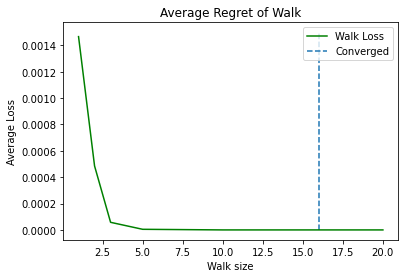

In [19]:
plt.plot(ks, walk_loss, color="green", label="Walk Loss")
plt.xlabel("Walk size")
plt.ylabel("Average Loss")
plt.title("Average Regret of Walk")
plt.vlines(x=16, linestyles='dashed', ymin=0, ymax=0.0015, label="Converged")
plt.legend()
plt.savefig("results/awalk_loss.png")

As we see there is very little advanage in increasing the step size and as a ratio a sizable tighening of variance. Also notice when k = None the result is essentially 0(it should be exactly 0 with perfect arithemtic)

# Regret Distribution
## Regret as a function of N


In [36]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)

vars_par = []
vars_seq = []
regrets_par = []
regrets_seq = []
uniform_res = []
n = 1500
ns = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
p0 = 1.1/n
p1 = np.log(n)/n

steps = 10
ps = np.linspace(p0, p1, steps)

for n in ns:
    print("n is ", n)
    n_trials = 15
    rho = 0.9
    a = 5
    c = 4
    p = np.sqrt(np.log(n))/n
    #[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
    [regret_par, regret_seq, uniform], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
    #vars_par.append(np.var(res_par))
    #vars_seq.append(np.var(res_seq))
    regrets_par.append(np.mean(regret_par))
    regrets_seq.append(np.mean(regret_seq))
    uniform_res.append(uniform)



n is  100
n is  500
n is  1000
n is  1500
n is  2000
n is  2500
n is  3000
n is  3500
n is  4000


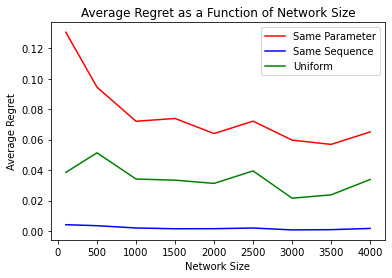

In [38]:
plt.plot(ns, regrets_par, color="red", label="Same Parameter")
plt.plot(ns, regrets_seq, color="blue", label="Same Sequence")
plt.plot(ns, uniform_res, color="green", label="Uniform")
plt.xlabel("Network Size")
plt.ylabel("Average Regret")
plt.title("Average Regret as a Function of Network Size")
plt.legend()
plt.savefig("results/regret_size.png")

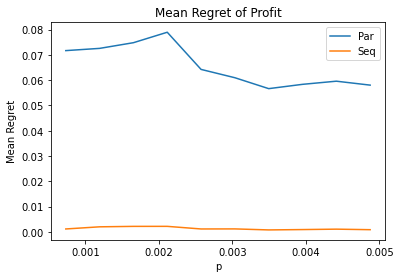

In [10]:
#plt.plot(ns, vars_par, label="Par")
#plt.plot(ns, vars_seq, label="Seq")
#plt.legend()
#plt.xlabel("n")
#plt.ylabel("Variance")
#plt.title("Variance of Profit")
#plt.show()
plt.plot(ps, regrets_par, label="Par")
plt.plot(ps, regrets_seq, label="Seq")
plt.xlabel("p")
plt.ylabel("Mean Regret")
plt.title("Mean Regret of Profit")
plt.legend()
plt.savefig("results/RegretVP.png")

## Function of p

In [39]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=np.inf)

vars_par = []
vars_seq = []
regrets_par = []
regrets_seq = []
regrets_uni = []
n = 2000
p0 = 1.1/n
p1 = np.log(n)/n
steps = 15
ps = np.linspace(p0, p1, steps)
i = 0
for p in ps:
    print("iteration i: ", i)
    i += 1
    n_trials = 15
    rho = 0.95
    a = 5
    c = 4
    #[res_par, res_seq], [ratio_par, ratio_seq] = profitDistribution(n,p,n_trials,  rho, a, c)
    [regret_par, regret_seq,uniform], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
    #vars_par.append(np.var(res_par))
    #vars_seq.append(np.var(res_seq))
    regrets_par.append(np.mean(regret_par))
    regrets_seq.append(np.mean(regret_seq))
    regrets_uni.append(uniform)



iteration i:  0
iteration i:  1
iteration i:  2
iteration i:  3
iteration i:  4
iteration i:  5
iteration i:  6
iteration i:  7
iteration i:  8
iteration i:  9
iteration i:  10
iteration i:  11
iteration i:  12
iteration i:  13
iteration i:  14


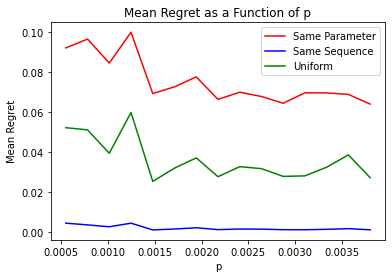

In [40]:
plt.plot(ps, regrets_par, color="red", label="Same Parameter")
plt.plot(ps, regrets_seq, color="blue", label="Same Sequence")
plt.plot(ps, regrets_uni, color="green", label="Uniform")
plt.xlabel("p")
plt.ylabel("Mean Regret")
plt.title("Mean Regret as a Function of p")
plt.legend()

# Variance 
## As a function of N

In [41]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)

vars_par = []
vars_seq = []
n = 1500
ns = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
p0 = 1.1/n
p1 = np.log(n)/n

steps = 10
ps = np.linspace(p0, p1, steps)

for n in ns:
    print("n is ", n)
    n_trials = 15
    rho = 0.9
    a = 5
    c = 4
    p = np.sqrt(np.log(n))/n
    [regret_par, regret_seq, uniform], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
    vars_par.append(np.var(regret_par))
    vars_seq.append(np.var(regret_seq))

n is  100
n is  500
n is  1000
n is  1500
n is  2000
n is  2500
n is  3000
n is  3500
n is  4000


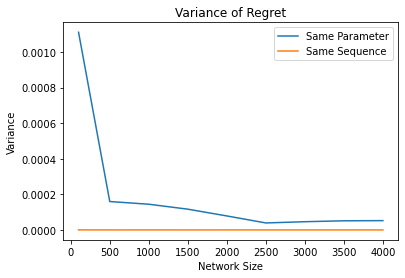

In [43]:
plt.plot(ns, vars_par, label="Same Parameter")
plt.plot(ns, vars_seq, label="Same Sequence")
plt.xlabel("Network Size")
plt.ylabel("Variance")
plt.title("Variance of Regret")
plt.legend()
plt.savefig("results/var_regret_size.png")


## As a function of p

In [53]:
def specNorm(A: np.matrix) -> float:
    return lin.norm(A, ord=1)

vars_par1 = []
vars_seq1 = []
n = 1500
ns = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
p0 = 1.1/n
p1 = np.log(n)/n

steps = 10
ps = np.linspace(p0, p1, steps)

for p in ps:
    print("n is ", n)
    n_trials = 15
    rho = 0.9
    a = 5
    c = 4
    aver_var_par = 0
    aver_var_seq = 0
    for i in range(5):
        [regret_par, regret_seq, uniform], [ratio_par, ratio_seq] = regretDistribution(n,p,n_trials,  rho, a, c)
        aver_var_par += np.var(regret_par)
        aver_var_seq += np.var(regret_seq)
    aver_var_par /= 5
    aver_var_seq /= 5
    vars_par1.append(aver_var_par)
    vars_seq1.append(aver_var_seq)

n is  1500
n is  1500
n is  1500
n is  1500
n is  1500
n is  1500
n is  1500
n is  1500
n is  1500
n is  1500


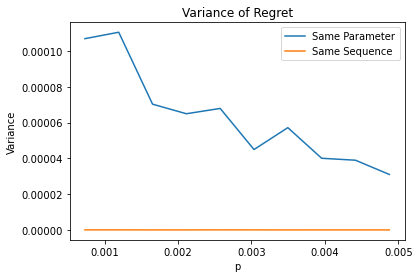

In [55]:
plt.plot(ps, vars_par1, label="Same Parameter")
plt.plot(ps, vars_seq1, label="Same Sequence")
plt.xlabel("p")
plt.ylabel("Variance")
plt.title("Variance of Regret")
plt.legend()
plt.savefig("results/var_regret_p.png")

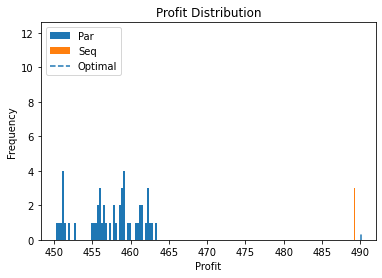

In [193]:
n = 2500
p = np.sqrt(np.log(n))/n
n_trials = 50
[results_par, results_seq, opt] = rawProfitDistribution(n,p, n_trials, rho, a, c);


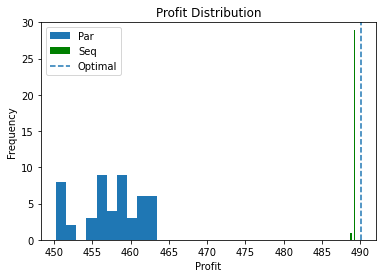

In [209]:
plt.hist(results_par , label="Par")
plt.hist(results_seq, color="green" , label="Seq")
plt.vlines(x=opt, linestyles='dashed', ymin=0, ymax=30, label="Optimal")
plt.legend()
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution")
plt.ylim(0,30)
plt.savefig("results/profit_dist.png")

In [210]:
print("Mean Profit", np.mean(results_par))
print("Mean Profit", np.mean(results_seq))
print("True Optimal Profit", opt)
print("Variance", np.var(results_par))
print("Variance", np.var(results_seq))


Mean Profit 457.3698497211146
Mean Profit 489.19017038886545
True Optimal Profit 490.0304612989641
Variance 14.377663783267547
Variance 0.00845921418834001


# Difffences in prices
## As a function of N

In [56]:
ns = [100, 500, 1000, 1500, 2000, 2500, 3000]
dif__par_l1 = []
dif__par_l2 = []
dif__par_inf = []
dif__seq_l1 = []
dif__seq_l2 = []
dif__seq_inf = []

for n in ns:
    print(n)
    p = np.sqrt(np.log(n))/n
    n_trials = 50
    [results_par_l1, results_seq_l1] = priceVectorDifference(n,p, n_trials, rho, a, c,1);
    [results_par_l2, results_seq_l2] = priceVectorDifference(n,p, n_trials, rho, a, c,2);
    [results_par_inf, results_seq_inf] = priceVectorDifference(n,p, n_trials, rho, a, c,np.inf);
    dif__par_l1.append(np.mean(results_par_l1))
    dif__par_l2.append(np.mean(results_par_l2))
    dif__par_inf.append(np.mean(results_par_inf))
    dif__seq_l1.append(np.mean(results_seq_l1))
    dif__seq_l2.append(np.mean(results_seq_l2))
    dif__seq_inf.append(np.mean(results_seq_inf))





100
500
1000
1500
2000
2500
3000


In [57]:
dif__par_l1 = [dif__par_l1[i]/ns[i] for i in range(len(dif__par_l1))]
dif__par_l2 = [dif__par_l2[i]/ns[i] for i in range(len(dif__par_l2))]
dif__seq_l1 = [dif__seq_l1[i]/ns[i] for i in range(len(dif__seq_l1))]
dif__seq_l2 = [dif__seq_l2[i]/ns[i] for i in range(len(dif__seq_l2))]

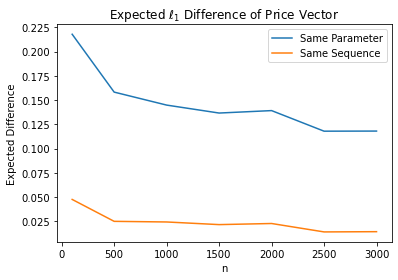

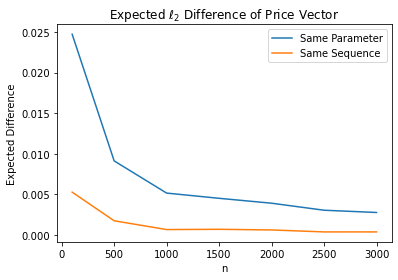

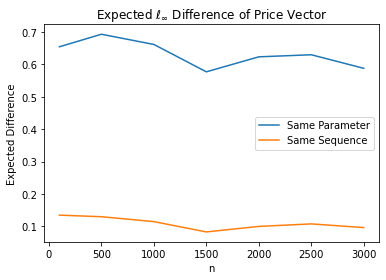

In [60]:
plt.plot(ns, dif__par_l1, label="Same Parameter")
plt.plot(ns, dif__seq_l1, label="Same Sequence")
plt.legend()
plt.xlabel("n")
plt.ylabel("Expected Difference")
plt.title("Expected $\ell_1$ Difference of Price Vector")
plt.savefig("results/aprice_vector_l1.png")
plt.show()
plt.close()
plt.plot(ns, dif__par_l2, label="Same Parameter")
plt.plot(ns, dif__seq_l2, label="Same Sequence")
plt.legend()
plt.xlabel("n")
plt.ylabel("Expected Difference")
plt.title("Expected $\ell_2$ Difference of Price Vector")
plt.savefig("results/aprice_vector_l2.png")
plt.show()
plt.close()
plt.plot(ns, dif__par_inf, label="Same Parameter")
plt.plot(ns, dif__seq_inf, label="Same Sequence")
plt.legend()
plt.xlabel("n")
plt.ylabel("Expected Difference")
plt.title("Expected $\ell_\infty$ Difference of Price Vector")
plt.savefig("results/aprice_vector_inf.png")


## Function of p

In [61]:
p0 = 1.1/n
p1 = np.log(n)/n
steps = 20
ps = np.linspace(p0, p1, steps)
dif__par_l1 = []
dif__par_l2 = []
dif__par_inf = []
dif__seq_l1 = []
dif__seq_l2 = []
dif__seq_inf = []
n=1500
for p in ps:
    n_trials = 50
    [results_par_l1, results_seq_l1] = priceVectorDifference(n,p, n_trials, rho, a, c,1);
    [results_par_l2, results_seq_l2] = priceVectorDifference(n,p, n_trials, rho, a, c,2);
    [results_par_inf, results_seq_inf] = priceVectorDifference(n,p, n_trials, rho, a, c,np.inf);
    dif__par_l1.append(np.mean(results_par_l1))
    dif__par_l2.append(np.mean(results_par_l2))
    dif__par_inf.append(np.mean(results_par_inf))
    dif__seq_l1.append(np.mean(results_seq_l1))
    dif__seq_l2.append(np.mean(results_seq_l2))
    dif__seq_inf.append(np.mean(results_seq_inf))

In [62]:
dif__par_l1 = [dif__par_l1[i]/1500 for i in range(len(dif__par_l1))]
dif__par_l2 = [dif__par_l2[i]/1500 for i in range(len(dif__par_l2))]
dif__seq_l1 = [dif__seq_l1[i]/1500 for i in range(len(dif__seq_l1))]
dif__seq_l2 = [dif__seq_l2[i]/1500 for i in range(len(dif__seq_l2))]

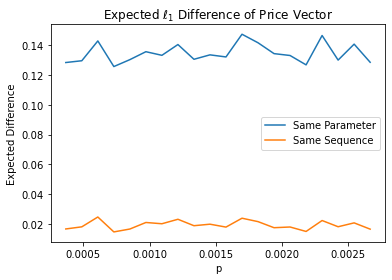

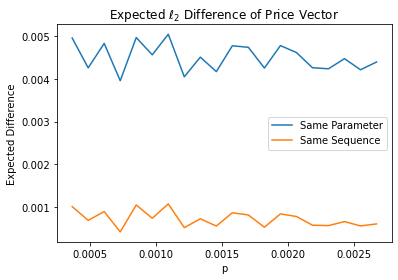

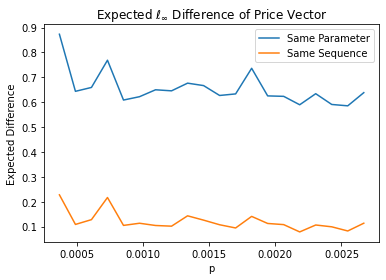

In [65]:
plt.plot(ps, dif__par_l1, label="Same Parameter")
plt.plot(ps, dif__seq_l1, label="Same Sequence")
plt.legend()
plt.xlabel("p")
plt.ylabel("Expected Difference")
plt.title("Expected $\ell_1$ Difference of Price Vector")
plt.savefig("results/vdif_vp_l1.png")
plt.show()
plt.plot(ps, dif__par_l2, label="Same Parameter")
plt.plot(ps, dif__seq_l2, label="Same Sequence")
plt.legend()
plt.xlabel("p")
plt.ylabel("Expected Difference")
plt.title("Expected $\ell_2$ Difference of Price Vector")
plt.savefig("results/vdif_vp_l2.png")
plt.show()
plt.plot(ps, dif__par_inf, label="Same Parameter")
plt.plot(ps, dif__seq_inf, label="Same Sequence")
plt.legend()
plt.xlabel("p")
plt.ylabel("Expected Difference")
plt.title("Expected $\ell_\infty$ Difference of Price Vector")
plt.savefig("results/vdif_vp_inf.png")
plt.show()

# Averaged Vector

In [67]:
ns = [100, 500, 1000, 1500, 2000, 2500]
res_seq = []
res_avg_seq = []
steps = 10
for n in ns:
    print("n is ", n)
    p = np.sqrt(np.log(n))/n
    n_trials = 10
    total_seq = 0
    totalavg_seq = 0
    for j in range(steps):
        [par,seq, avg], [ratio_par, ratio_seq] = regretAveragedVector(n,p, n_trials, rho, a, c);
        total_seq += np.average(seq)
        totalavg_seq += avg
    res_seq.append(total_seq/steps)
    res_avg_seq.append(totalavg_seq/steps)

    
    


n is  100
n is  500
n is  1000
n is  1500
n is  2000
n is  2500


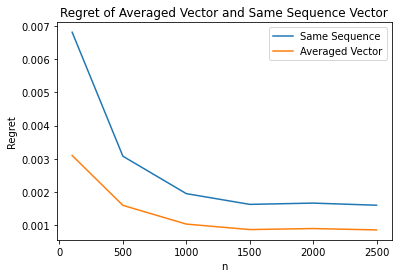

In [68]:
plt.plot(ns, res_seq, label="Same Sequence")
plt.plot(ns, res_avg_seq, label="Averaged Vector")
plt.legend()
plt.xlabel("n")
plt.ylabel("Regret")
plt.title("Regret of Averaged Vector and Same Sequence Vector")
plt.savefig("results/RegretAveragedVector.png")

In [116]:
print("Regret Par", np.mean(par))
print("Regret Seq", np.mean(seq))
print("Regret Avg", np.mean(avg))
print("Variance", np.var(par))
print("Variance", np.var(seq))

Regret Par 0.06708519163455745
Regret Seq 0.0016099377768705903
Regret Avg 0.0008099999724531237
Variance 5.351546578418717e-05
Variance 1.4382023333713627e-09
